# Try and rewrite some aspects of Gamma

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import lightkurve as lk
from astropy.units import cds
from astropy import units as u

import corner
import pystan
import pymc3
import pickle
import os

Lets read in a handful of modes

In [2]:
locs = np.genfromtxt('../locs.txt')
mid = int(np.floor(len(locs)/2))
l0s = locs[mid:mid+1,0]
l1s = locs[mid:mid+1,1]
l2s = locs[mid-1:mid,2]
modelocs = np.append(l0s, l2s)
modeids = [0]*len(l0s)  + [2]*len(l2s)

# l0s = locs[:,0]
# l1s = locs[:,1]
# l2s = locs[:,2]
modelocs = np.array([l0s, l1s, l2s]).flatten()
modeids = [0]*len(l0s)  + [1]*len(l1s) + [2]*len(l2s)

In [3]:
ff = np.genfromtxt('../freqs.txt')
pp = np.genfromtxt('../model.txt')
sel = [(ff >= np.min(modelocs)-25) & (ff <= np.max(modelocs+25))]
f = ff[tuple(sel)]
p = pp[tuple(sel)] 

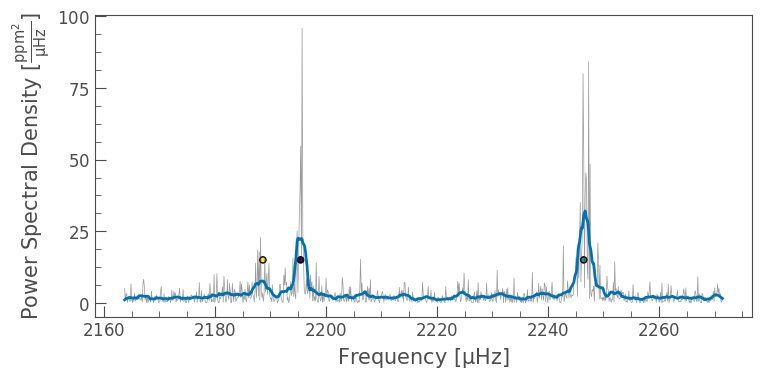

In [4]:
pg = lk.Periodogram(f*u.microhertz, p*(cds.ppm**2/u.microhertz))
ax = pg.plot(alpha=.5)
pg.smooth(filter_width=2.).plot(ax=ax, linewidth=2)
plt.scatter(modelocs, [15]*len(modelocs),c=modeids, s=20, edgecolor='k')
plt.show()

In [5]:
gpgamma = '''
functions{      
    vector lorentzian(real loc, int l, int m, vector f, real eps, real H, real w, real nus){
        return (eps * H) ./ (1 + (4/w^2) * square(f - loc + m*nus));
    }
}
data{
    int N;            // Number of data points
    int M;            // Number of modes
    vector[N] f;      // Frequency
    vector[N] p;      // Power
    real pr_locs[M];  // Mode locations guesses
    int ids[M];       // The ID's of the modes
    real rho;         // The length scale of the GP Gamma prior
}
parameters{
    real logAmp[M];         // Mode amplitude in log space
    vector<lower=0>[M] w;   // Mode linewidth in log space
    real locs[M];           // True mode locations
    real<lower=0> vsini;    //  Sin of angle of inclination x rotational splitting
    real<lower=0> vcosi;    //  Cos of angle of inclination x rotational splitting
    real<lower=0> b;        // Background
    real<lower=0.> alpha;   // Spread on the squared exponential kernel
}
transformed parameters{
    real H[M];                           // Mode height
    real nus = sqrt(vsini^2 + vcosi^2);
    real i   = acos(vcosi / nus);   
    matrix[M, M] cov = cov_exp_quad(locs, alpha, rho)
                        + diag_matrix(rep_vector(1e-10, M));
    matrix[M, M] L_cov = cholesky_decompose(cov);
    
    for (m in 1:M){
        H[m] = 10^logAmp[m] / pi() / w[m]; // Transform mode amplitude to mode height
    }
}
model{
    vector[N] modes; // Our Model
    matrix[4,4] eps; // Matrix of legendre polynomials
    int l;           // The radial degree
    real nus_mu    = 0.5;  
    vector[M] w_mu = rep_vector(1., M);     
    
    // Calculate all the legendre polynomials for this i
    eps = rep_matrix(1., 4, 4);
    eps[0+1,0+1] = 1.;
    eps[1+1,0+1] = cos(i)^2;
    eps[1+1,1+1] = 0.5 * sin(i)^2;
    eps[2+1,0+1] = 0.25 * (3. * cos(i)^2 - 1.)^2;
    eps[2+1,1+1] = (3./8.)*sin(2*i)^2;
    eps[2+1,2+1] = (3./8.) * sin(i)^4;
    eps[3+1,0+1] = (1./64.)*(5.*cos(3.*i) + 3.*cos(i))^2;
    eps[3+1,1+1] = (3./64.)*(5.*cos(2.*i) + 3.)^2 * sin(i)^2;
    eps[3+1,2+1] = (15./8.)*cos(i)^2 * sin(i)^4;
    eps[3+1,3+1] = (5./16.)*sin(i)^6;    

        
    // Generating our model
    modes = rep_vector(b, N);
    for (mode in 1:M){        // Iterate over all modes passed in
        l = ids[mode];    // Identify the Mode ID
        for (m in -l:l){      // Iterate over all m in a given l
            modes += lorentzian(locs[mode], l, m, f, eps[l+1,abs(m)+1], H[mode], w[mode], nus);
        }
    }

    // Model drawn from a gamma distribution scaled to the model (Anderson+1990)
    p ~ gamma(1., 1../modes);
    
    //priors on the parameters
    logAmp ~ normal(1.5, 1.);
    locs ~ normal(pr_locs, 1);
    nus_mu ~ normal(nus, 1.);
    vsini ~ uniform(0,nus);
    
    alpha ~ normal(2.5, 1.);
    w_mu ~ multi_normal_cholesky(w, L_cov);
    
    b ~ normal(1.,.1);
}
'''
sm = pystan.StanModel(model_code = gpgamma, model_name='gpgamma')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL gpgamma_af98d583eb4f8deac29881729993bcaa NOW.


In [6]:
nus = 0.411 #uHz
i = np.deg2rad(56.) #rad
dnu = 102. #uHz

data = {'N':len(f),
        'M': len(modelocs),
        'f':f,
        'p':p,
        'pr_locs':modelocs,
        'ids':modeids,
        'rho':250.}

init = {'logAmp' :   np.ones(len(modelocs))*1.5,
        'w' : np.ones(len(modelocs)),
        'vsini' : nus*np.sin(i),
        'vcosi' : nus*np.cos(i),
        'i' : i,
        'nus': nus,
        'locs' : modelocs,
        'alpha':2.5,
        'b':1.}

In [7]:
nchains = 4
fit = sm.sampling(data=data, iter=1000, chains=nchains, seed=1895,
                  init = [init for n in range(nchains)])

In [8]:
print(fit)

Inference for Stan model: gpgamma_af98d583eb4f8deac29881729993bcaa.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
logAmp[1]   2.09  2.7e-3   0.08   1.94   2.04   2.09   2.15   2.26    888    1.0
logAmp[2]   2.32  2.6e-3   0.07   2.19   2.27   2.31   2.36   2.45    639   1.01
logAmp[3]    1.7  5.6e-3   0.12   1.46   1.63   1.69   1.78   1.92    427   1.02
w[1]         1.9    0.02   0.42   1.22   1.62   1.83   2.19   2.82    421    1.0
w[2]        1.91    0.02    0.4   1.22   1.65   1.87   2.14   2.79    653    1.0
w[3]        1.89    0.02   0.44   1.18   1.59   1.82   2.19   2.87    419    1.0
locs[1]   2195.4  7.4e-3   0.18 2195.1 2195.3 2195.4 2195.6 2195.8    620    1.0
locs[2]   2246.6    0.02   0.19 2246.2 2246.5 2246.6 2246.7 2247.0    158   1.03
locs[3]   2188.1    0.01   0.36 2187.3 2187.9 2188.1 2188.3 2188.7   1191   1.01
vsini 

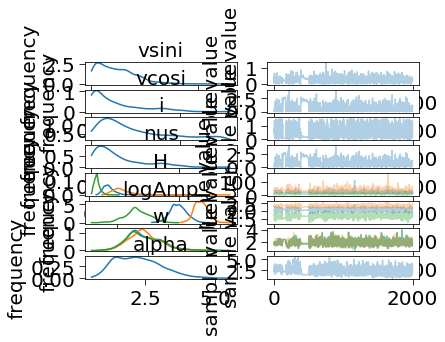

In [9]:
fit.plot(pars=['vsini','vcosi','i','nus','H','logAmp','w','alpha'])
plt.show()

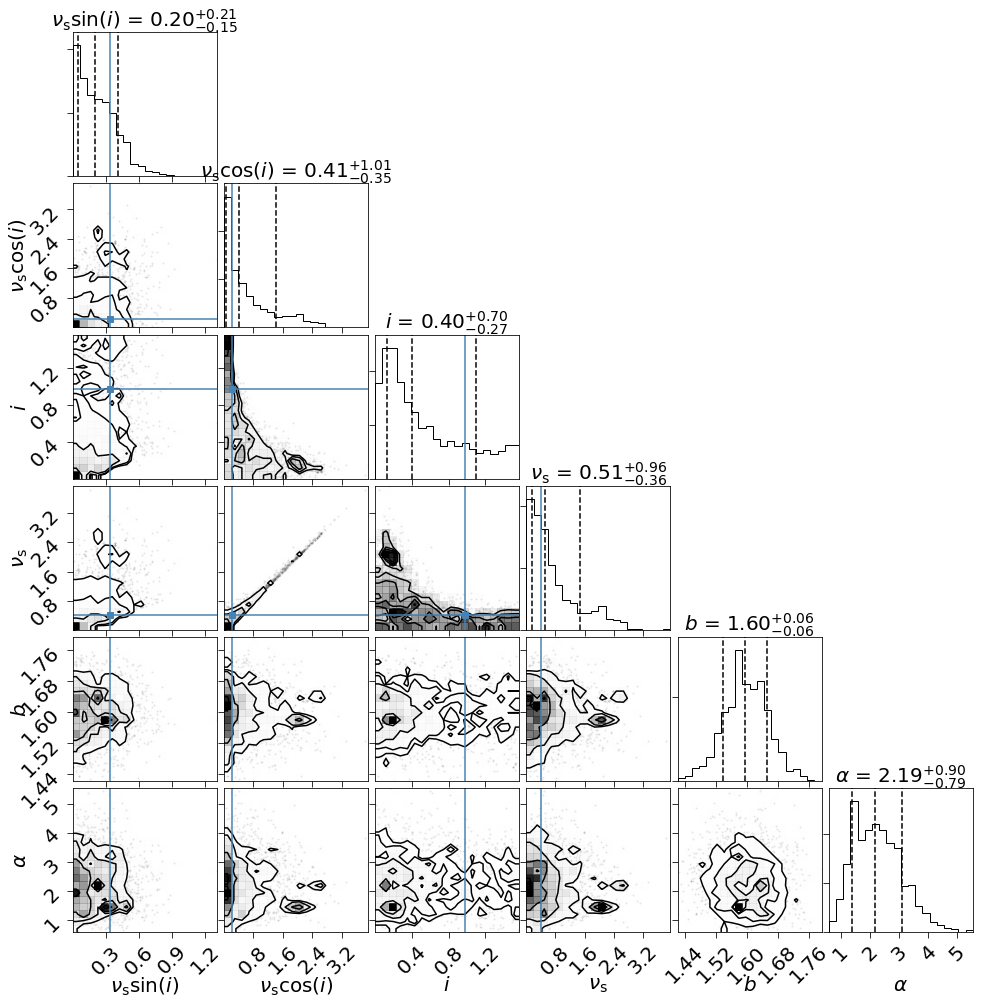

l = 0


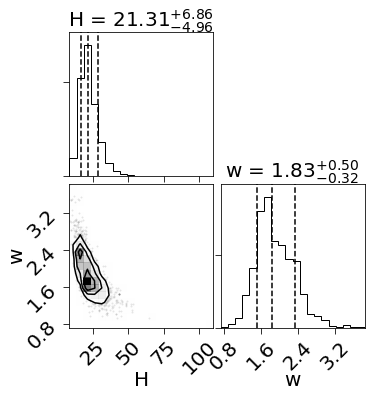

l = 1


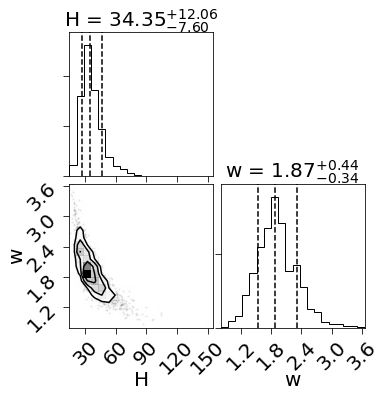

l = 2


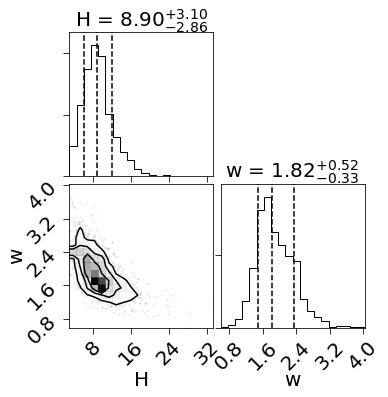

In [10]:
truths= [init['vsini'],init['vcosi'],init['i'],init['nus'], np.nan, np.nan]
labels=['vsini','vcosi','i','nus', 'b', 'alpha']
chain = np.array([fit[label] for label in labels])
verbose = [r'$\nu_{\rm s}\sin(i)$',r'$\nu_{\rm s}\cos(i)$',r'$i$',
            r'$\nu_{\rm s}$', r'$b$', r'$\alpha$']
corner.corner(chain.T, labels=verbose, quantiles=[0.16, 0.5, 0.84],
            truths=truths,show_titles=True)
plt.show()

for idx in range(len(fit['H'].T)):
    chain = np.array([fit['H'].T[idx], fit['w'].T[idx]])
    corner.corner(chain.T, labels=['H','w'], quantiles=[0.16, 0.5, 0.84],show_titles=True)
    print('l = {}'.format(modeids[idx]))   
    plt.show()

In [11]:
def get_epsilon(i, l, m):
#I use the prescriptions from Gizon & Solank 2003 and Handberg & Campante 2012
    if l == 0:
        return 1
    if l == 1:
        if m == 0:
            return np.cos(i)**2
        if np.abs(m) == 1:
            return 0.5 * np.sin(i)**2
    if l == 2:
        if m == 0:
            return 0.25 * (3 * np.cos(i)**2 - 1)**2
        if np.abs(m) ==1:
            return (3/8)*np.sin(2*i)**2
        if np.abs(m) == 2:
            return (3/8) * np.sin(i)**4
    if l == 3:
        if m == 0:
            return (1/64)*(5*np.cos(3*i) + 3*np.cos(i))**2
        if np.abs(m) == 1:
            return (3/64)*(5*np.cos(2*i) + 3)**2 * np.sin(i)**2
        if np.abs(m) == 2:
            return (15/8) * np.cos(i)**2 * np.sin(i)**4
        if np.abs(m) == 3:
            return (5/16)*np.sin(i)**6
    
def lorentzian(f, l, m, loc, i, H, w, nus):
    eps = get_epsilon(i,l,m)
    model = eps * H / (1 + (4/w**2)*(f - loc + m * nus)**2)
    return model

model = np.ones(len(f))
nus = np.median(fit['nus'])
for mode in range(len(modeids)):
    l = modeids[mode]
    for m in range(-l, l+1):
        loc = np.median(fit['locs'].T[mode])
        H = np.median(fit['H'].T[mode])
        w = np.median(fit['w'].T[mode])
        model += lorentzian(f, l, m, loc, i, H, w, nus)
fitlocs = np.median(fit['locs'],axis=0)

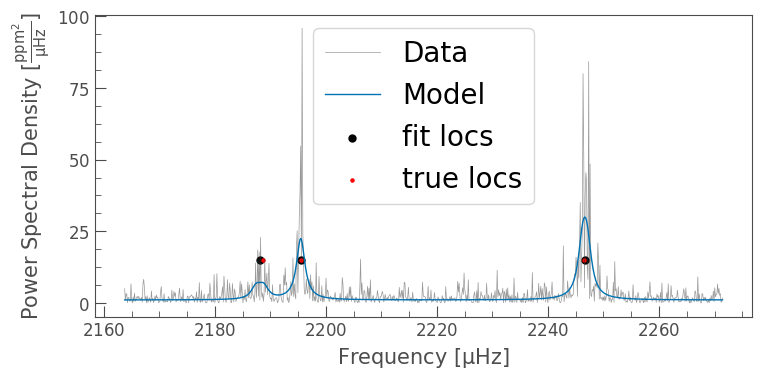

In [12]:
pg = lk.Periodogram(f*u.microhertz, p*(cds.ppm**2/u.microhertz))
ax = pg.plot(alpha=.5, label='Data')
plt.scatter(fitlocs, [15]*len(fitlocs),c='k',s=25, label='fit locs')
plt.scatter(modelocs, [15]*len(modelocs),c='r',s=5, label='true locs')
plt.plot(f, model, linewidth=1, label='Model')
plt.legend()

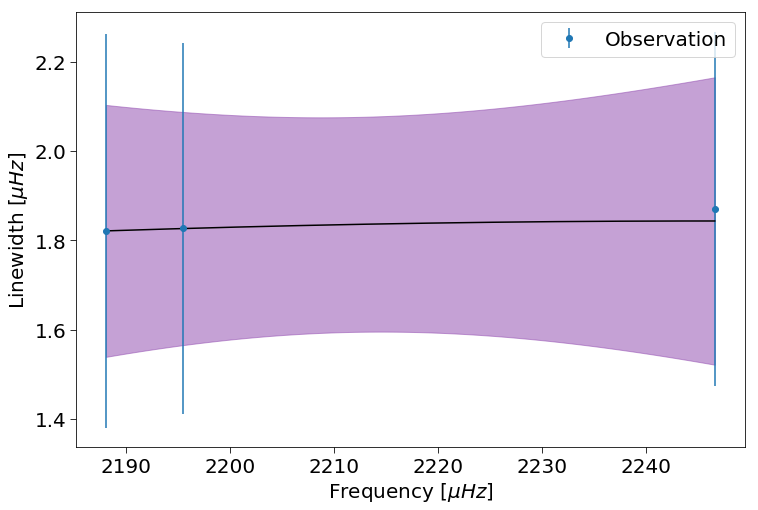

In [13]:
def kernel(x, y, p):
    ''' Returns a sqaured exponetial covariance matrix '''
    # p[0] = sigma
    # p[1] = length scale
    return p[0]**2 * np.exp(-0.5 * np.subtract.outer(x, y)**2 / p[1]**2)    

def predict(t_2, t_1, kernel, theta, a, c, y_1, y_v):
    B = kernel(t_1, t_2, theta).T
    A = kernel(t_1, t_1, theta).T + np.diag(y_v)
    C = kernel(t_2, t_2, theta).T
    
    y = c + np.dot(np.dot(B, np.linalg.inv(A)), (y_1 - a))
    Sigma = C - np.dot(np.dot(B, np.linalg.inv(A)),B.T)
            
    y_pred = y 
    sigma_new = np.sqrt(np.diagonal(Sigma))
    return y_pred, sigma_new

def plot_GP(ax, t_1, t_2, y_1, s, y_pred, sigmas, label='Observation'):
    ax.fill_between(t_2, y_pred-sigmas, y_pred+sigmas, alpha=.5, color='#8d44ad')
    ax.plot(t_2, y_pred, c='k')
    ax.errorbar(t_1, y_1, yerr=s, fmt='o', capsize=0, label=label)
    ax.legend(fontsize=15)
    ax.set_ylabel(r'Linewidth [$\mu Hz$]', fontsize=20)
    ax.set_xlabel(r'Frequency [$\mu Hz$]', fontsize=20)
    ax.legend(fontsize=20)
    return ax

ws = np.median(fit['w'], axis=0)
ws_std = np.std(fit['w'],axis=0)
flocs = np.median(fit['locs'], axis=0)
alpha = np.median(fit['alpha'])
rho = data['rho']

npts = 500

a = np.ones(len(flocs))
c = np.ones(npts)

flocs2 = np.linspace(np.min(flocs), np.max(flocs), npts)

theta = [alpha, rho]
ws_pred, sigmas = predict(flocs2, flocs, kernel, theta, a, c, ws, ws_std**2)

fig, ax = plt.subplots(figsize=(12,8))
ax = plot_GP(ax, flocs, flocs2, ws, ws_std, ws_pred, sigmas)